## Config
More than one machine can be available at each timestep

Saved URLLC_M1_trace.csv (827 packets)
Saved URLLC_M2_trace.csv (589 packets)
Saved eMBB_M3_trace.csv (230 packets)
Saved eMBB_M4_trace.csv (183 packets)
Saved mMTC_M5_trace.csv (194 packets)
Saved all_traces.csv (2023 packets total)


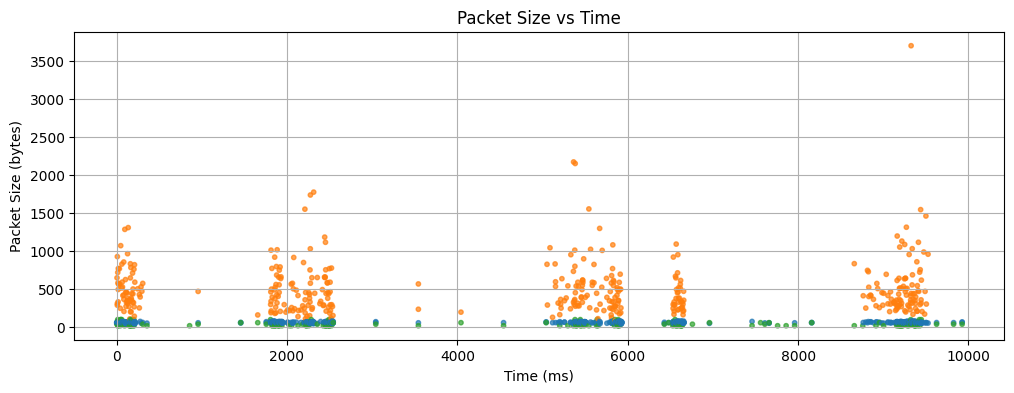

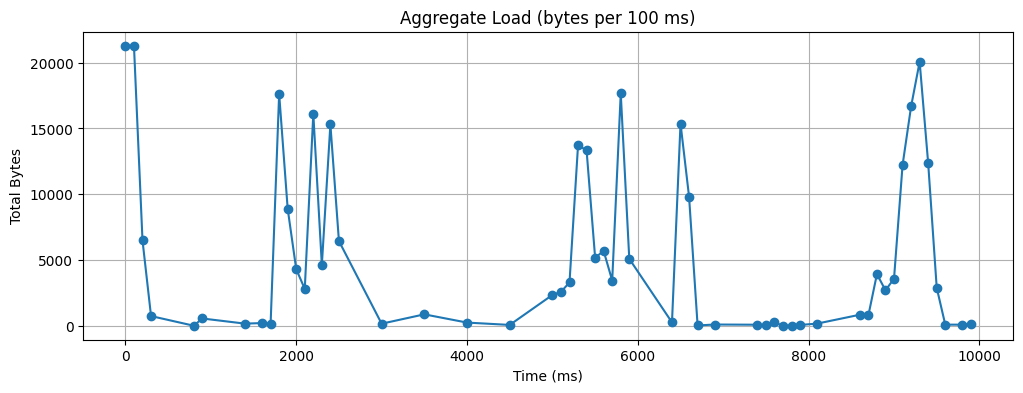

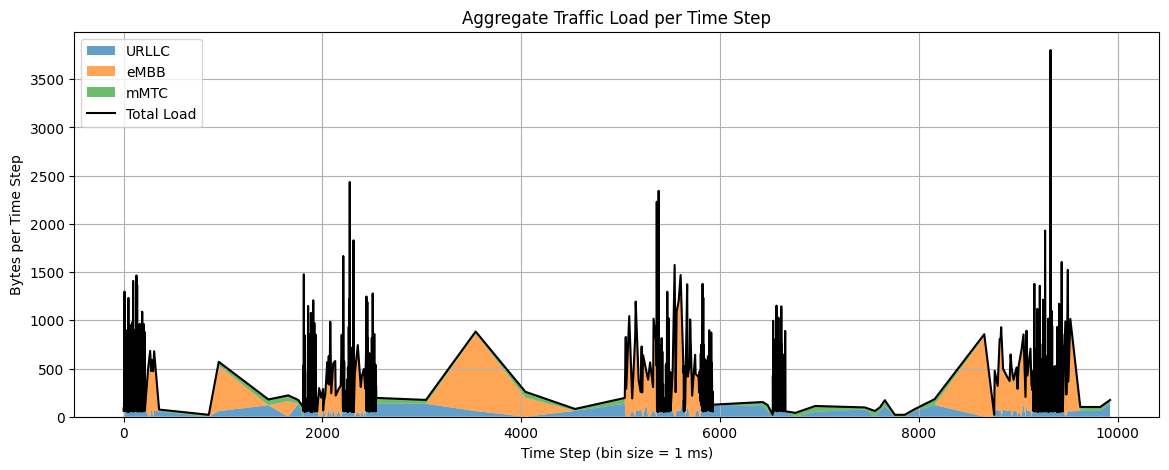

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

# =============================
# Config
# =============================
np.random.seed(11)
random.seed(11)

# Define your machines (UEs) — means/stds are per-machine even within the same slice
machines_config = [
    {"name": "M1", "slice": "URLLC", "dist": "normal",    "mean": 60,  "std": 5,  "ip": "10.0.0.1"},
    {"name": "M2", "slice": "URLLC", "dist": "normal",    "mean": 65,  "std": 7,  "ip": "10.0.0.2"},
    {"name": "M3", "slice": "eMBB",  "dist": "lognormal", "mean": 6.0, "std": 0.5,"ip": "10.0.0.3"},
    {"name": "M4", "slice": "eMBB",  "dist": "lognormal", "mean": 6.2, "std": 0.6,"ip": "10.0.0.4"},
    {"name": "M5", "slice": "mMTC",  "dist": "discrete",  "values": [20,40,60,100], "probs": [0.4,0.3,0.2,0.1], "ip": "10.0.0.5"},
]

# Interarrival distributions per slice (milliseconds)
interarrival_ms = {
    "URLLC": [0.5, 1, 1.5, 2],     # very frequent
    "eMBB":  [5, 10, 20, 30],      # moderate
    "mMTC":  [50, 100, 200, 500],  # sparse
}

# Uplink probability per slice (probability that direction is UE->Server)
uplink_ratio = {
    "URLLC": 0.20,
    "eMBB":  0.30,
    "mMTC":  0.95,
}

# Probability that an additional machine joins as "secondary" active machine this event
p_extra_base = 0.15  # baseline chance
p_extra_urlcc_boost = 2.0  # URLLC machines have higher chance: p_extra_base * boost

# Simulation duration (ms) and plotting bin
sim_duration_ms = 10_000
plot_bin_ms = 100  # for aggregate line plot; stacked area uses 1 ms by default

# Server IP
server_ip = "192.168.0.1"

# =============================
# Sampling helpers
# =============================
def sample_packet(machine):
    if machine["dist"] == "normal":
        return max(1.0, float(np.random.normal(machine["mean"], machine["std"])))
    elif machine["dist"] == "lognormal":
        # lognormal uses mean, std in log-space
        return float(np.random.lognormal(machine["mean"], machine["std"]))
    elif machine["dist"] == "discrete":
        return float(np.random.choice(machine["values"], p=machine["probs"]))
    else:
        raise ValueError("Unknown dist: " + str(machine["dist"]))

def sample_interarrival(slice_type):
    return float(random.choice(interarrival_ms[slice_type]))

def sample_direction(machine_ip, slice_type):
    if random.random() < uplink_ratio[slice_type]:
        return "UL", machine_ip, server_ip
    else:
        return "DL", server_ip, machine_ip

# =============================
# Biased Markov: primary machine
# =============================
def biased_transition_probs(state_idx, machines):
    """
    URLLC gets high persistence and higher incoming probability.
    Non-URLLC has lower persistence and smaller cross-probabilities.
    """
    N = len(machines)
    probs = np.zeros(N, dtype=float)
    current_slice = machines[state_idx]["slice"]
    if current_slice == "URLLC":
        # Very sticky URLLC
        probs[state_idx] = 0.98
        others = [i for i in range(N) if i != state_idx]
        if others:
            jump = 0.02 / len(others)
            for i in others:
                probs[i] = jump
    else:
        # Less sticky for others
        probs[state_idx] = 0.85
        others = [i for i in range(N) if i != state_idx]
        if others:
            # split remaining among URLLC and non-URLLC targets with a bias toward URLLC
            urlcc_targets = [i for i in others if machines[i]["slice"] == "URLLC"]
            other_targets = [i for i in others if machines[i]["slice"] != "URLLC"]
            mass_to_urlcc = 0.10
            mass_to_others = 0.05
            if urlcc_targets:
                for i in urlcc_targets:
                    probs[i] = mass_to_urlcc / len(urlcc_targets)
            if other_targets:
                for i in other_targets:
                    probs[i] = mass_to_others / len(other_targets)
    # numerical safety
    probs = probs / probs.sum()
    return probs

def biased_active_set(primary_idx, machines, p_extra=p_extra_base):
    """
    Decide which machines are active this event.
    Always include primary. Others can join; URLLC machines are more likely.
    """
    N = len(machines)
    active = {primary_idx}
    for i in range(N):
        if i == primary_idx:
            continue
        join_prob = p_extra
        if machines[i]["slice"] == "URLLC":
            join_prob *= p_extra_urlcc_boost
        if random.random() < join_prob:
            active.add(i)
    return active

# =============================
# Simulation
# =============================
packet_rows = []
current_time = 0.0
N = len(machines_config)
state = 0  # start from first machine

while current_time < sim_duration_ms:
    # Choose primary machine via biased Markov
    probs = biased_transition_probs(state, machines_config)
    state = int(np.random.choice(range(N), p=probs))

    # Build active set (primary + optional others)
    active_set = biased_active_set(state, machines_config)

    # Advance clock using the primary machine's slice interarrival
    delta = sample_interarrival(machines_config[state]["slice"])
    current_time += delta
    if current_time > sim_duration_ms:
        break

    # Generate one packet for each active machine at this timestamp
    for m_idx in active_set:
        m = machines_config[m_idx]
        size = sample_packet(m)
        direction, src_ip, dst_ip = sample_direction(m["ip"], m["slice"])
        packet_rows.append({
            "Time": round(current_time, 3),
            "machine": m["name"],
            "slice": m["slice"],
            "direction": direction,     # "UL" or "DL"
            "Source": src_ip,
            "Destination": dst_ip,
            "Length": round(size, 2),
        })

# =============================
# DataFrame + CSVs
# =============================
trace_df = pd.DataFrame(packet_rows)
trace_df = trace_df.sort_values(["Time", "machine"]).reset_index(drop=True)

# Save per-UE CSVs (slice_machine_trace.csv)
for (slice_type, machine), grp in trace_df.groupby(["slice", "machine"]):
    fname = f"{slice_type}_{machine}_trace.csv"
    grp.to_csv(fname, index=False)
    print(f"Saved {fname} ({len(grp)} packets)")

# Also save combined CSV
trace_df.to_csv("all_traces.csv", index=False)
print(f"Saved all_traces.csv ({len(trace_df)} packets total)")

# =============================
# Plots
# =============================

# 1) Packet size vs time (scatter)
plt.figure(figsize=(12, 4))
color_map = {"URLLC": "tab:blue", "eMBB": "tab:orange", "mMTC": "tab:green"}
plt.scatter(
    trace_df["Time"],
    trace_df["Length"],
    c=[color_map[s] for s in trace_df["slice"]],
    s=10, alpha=0.7
)
plt.title("Packet Size vs Time")
plt.xlabel("Time (ms)")
plt.ylabel("Packet Size (bytes)")
plt.grid(True)
plt.show()

# 2) Aggregate load line plot (bytes per plot_bin_ms)
trace_df["time_bin"] = (trace_df["Time"] // plot_bin_ms) * plot_bin_ms
agg = trace_df.groupby("time_bin")["Length"].sum()
plt.figure(figsize=(12, 4))
plt.plot(agg.index, agg.values, marker="o")
plt.title(f"Aggregate Load (bytes per {int(plot_bin_ms)} ms)")
plt.xlabel("Time (ms)")
plt.ylabel("Total Bytes")
plt.grid(True)
plt.show()

# 3) Stacked area per slice + total line (1 ms bins for a fine-grained view)
bin_size_sa = 1  # 1 ms
trace_df["time_bin_sa"] = (trace_df["Time"] // bin_size_sa).astype(int)
pivot = trace_df.pivot_table(
    index="time_bin_sa", columns="slice", values="Length",
    aggfunc="sum", fill_value=0
).sort_index()

for s in ["URLLC", "eMBB", "mMTC"]:  # ensure all columns exist
    if s not in pivot.columns:
        pivot[s] = 0

pivot["Total"] = pivot[["URLLC", "eMBB", "mMTC"]].sum(axis=1)

plt.figure(figsize=(14, 5))
plt.stackplot(
    pivot.index,
    pivot["URLLC"], pivot["eMBB"], pivot["mMTC"],
    labels=["URLLC", "eMBB", "mMTC"], alpha=0.7
)
plt.plot(pivot.index, pivot["Total"], color="black", linewidth=1.5, label="Total Load")
plt.title("Aggregate Traffic Load per Time Step")
plt.xlabel(f"Time Step (bin size = {bin_size_sa} ms)")
plt.ylabel("Bytes per Time Step")
plt.legend()
plt.grid(True)
plt.show()


In [2]:
import random
import pandas as pd

# 1. Build global time axis using all unique times
time_axis = pd.Series(sorted(trace_df["Time"].unique()))

# 2. Per-machine alignment
for (slice_type, machine), group in trace_df.groupby(["slice", "machine"]):
    # Use time as index
    df = group.set_index("Time").sort_index()

    # Reindex to global axis (preserves fractional times)
    df = df.reindex(time_axis)

    # Restore time column
    df = df.reset_index().rename(columns={"index": "Time"})

    # Fill fixed columns
    df["machine"] = machine
    df["slice"] = slice_type

    # Fill Length: NaN → 0
    df["Length"] = df["Length"].fillna(0)

    # Fill direction: keep real values, randomize only when missing
    directions = ["UL", "DL"]
    df["direction"] = df.apply(
        lambda row: row["direction"] if pd.notna(row["direction"]) 
        else random.choice(directions),
        axis=1
    )

    # Fill IPs: keep real, assign when missing
    machine_ip = machines_config[[m["name"] for m in machines_config].index(machine)]["ip"]
    server_ip = "192.168.0.1"
    def assign_ips(row):
        if pd.notna(row["Source"]) and pd.notna(row["Destination"]):
            return row["Source"], row["Destination"]
        if row["direction"] == "UL":
            return machine_ip, server_ip
        else:
            return server_ip, machine_ip

    df[["Source", "Destination"]] = df.apply(assign_ips, axis=1, result_type="expand")

    # Save aligned CSV
    fname = f"{slice_type}_{machine}_aligned_trace.csv"
    df.to_csv(fname, index=False)
    print(f"Saved {fname} with {len(df)} rows (aligned to global axis)")


Saved URLLC_M1_aligned_trace.csv with 1149 rows (aligned to global axis)
Saved URLLC_M2_aligned_trace.csv with 1149 rows (aligned to global axis)
Saved eMBB_M3_aligned_trace.csv with 1149 rows (aligned to global axis)
Saved eMBB_M4_aligned_trace.csv with 1149 rows (aligned to global axis)
Saved mMTC_M5_aligned_trace.csv with 1149 rows (aligned to global axis)


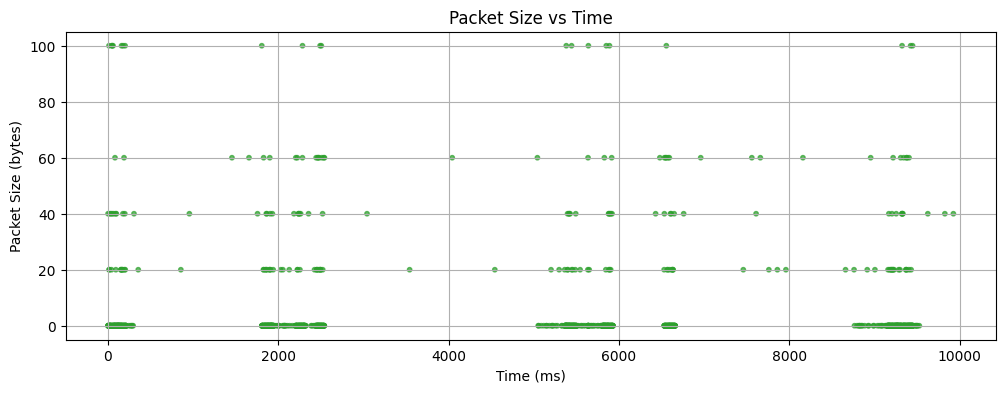

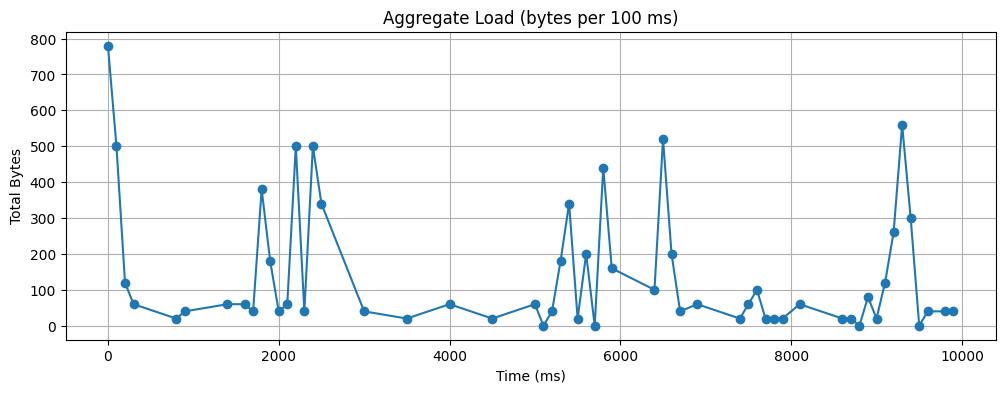

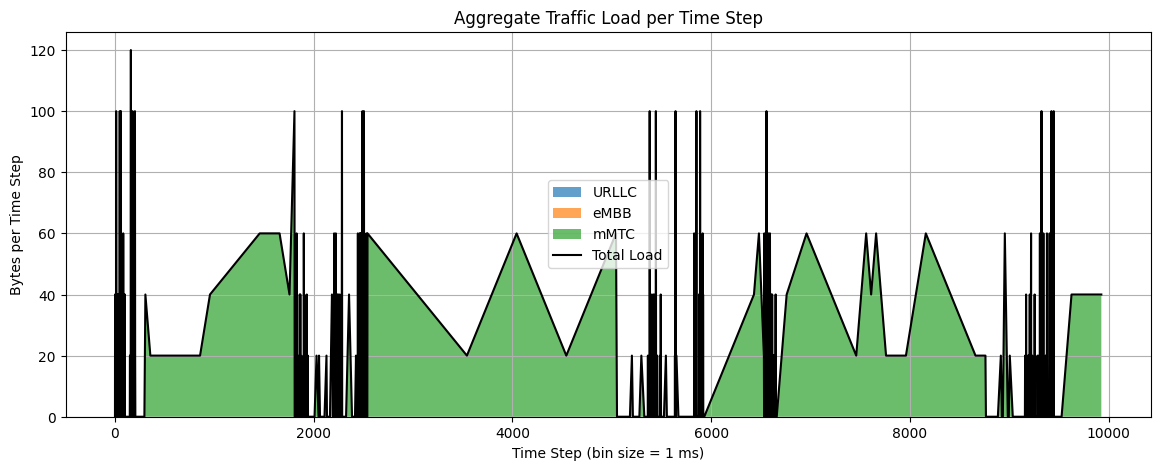

In [ ]:
# =============================
# Plots
# =============================

# 1) Packet size vs time (scatter)
plt.figure(figsize=(12, 4))
color_map = {"URLLC": "tab:blue", "eMBB": "tab:orange", "mMTC": "tab:green"}
plt.scatter(
    df["Time"],
    df["Length"],
    c=[color_map[s] for s in df["slice"]],
    s=10, alpha=0.7
)
plt.title("Packet Length vs Time")
plt.xlabel("Time (ms)")
plt.ylabel("Packet Length (bytes)")
plt.grid(True)
plt.show()

# 2) Aggregate load line plot (bytes per plot_bin_ms)
df["time_bin"] = (df["Time"] // plot_bin_ms) * plot_bin_ms
agg = df.groupby("time_bin")["Length"].sum()
plt.figure(figsize=(12, 4))
plt.plot(agg.index, agg.values, marker="o")
plt.title(f"Aggregate Load (bytes per {int(plot_bin_ms)} ms)")
plt.xlabel("Time (ms)")
plt.ylabel("Total Bytes")
plt.grid(True)
plt.show()

# 3) Stacked area per slice + total line (1 ms bins for a fine-grained view)
bin_size_sa = 1  # 1 ms
df["time_bin_sa"] = (df["Time"] // bin_size_sa).astype(int)
pivot = df.pivot_table(
    index="time_bin_sa", columns="slice", values="Length",
    aggfunc="sum", fill_value=0
).sort_index()

for s in ["URLLC", "eMBB", "mMTC"]:  # ensure all columns exist
    if s not in pivot.columns:
        pivot[s] = 0

pivot["Total"] = pivot[["URLLC", "eMBB", "mMTC"]].sum(axis=1)

plt.figure(figsize=(14, 5))
plt.stackplot(
    pivot.index,
    pivot["URLLC"], pivot["eMBB"], pivot["mMTC"],
    labels=["URLLC", "eMBB", "mMTC"], alpha=0.7
)
plt.plot(pivot.index, pivot["Total"], color="black", linewidth=1.5, label="Total Load")
plt.title("Aggregate Traffic Load per Time Step")
plt.xlabel(f"Time Step (bin size = {bin_size_sa} ms)")
plt.ylabel("Bytes per Time Step")
plt.legend()
plt.grid(True)
plt.show()


### Plot the generated files

Current working dir: /home/elahe/user/elahe/new-ai-ran-sim/backend/notebooks


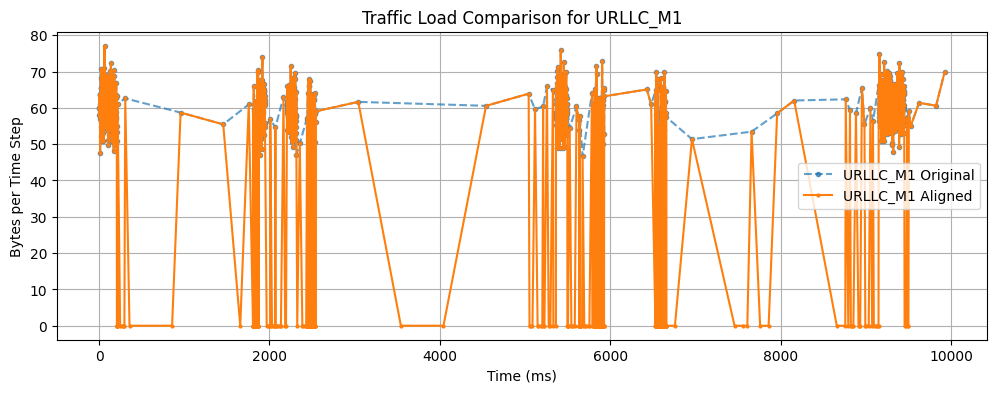

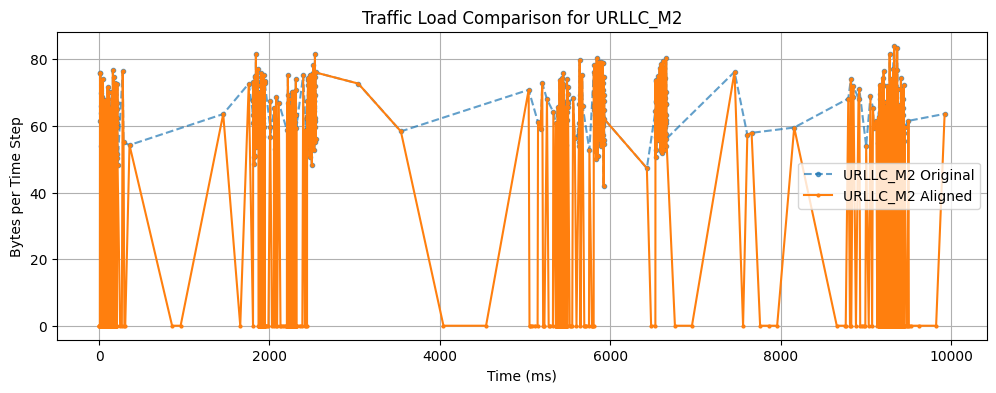

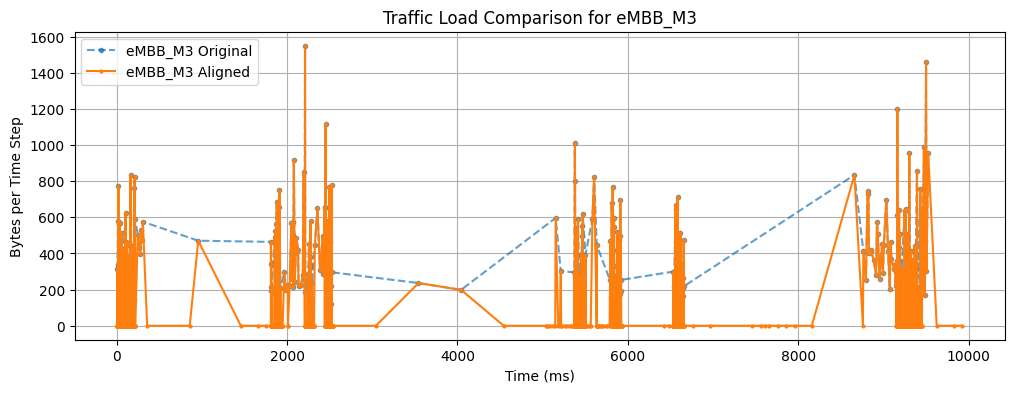

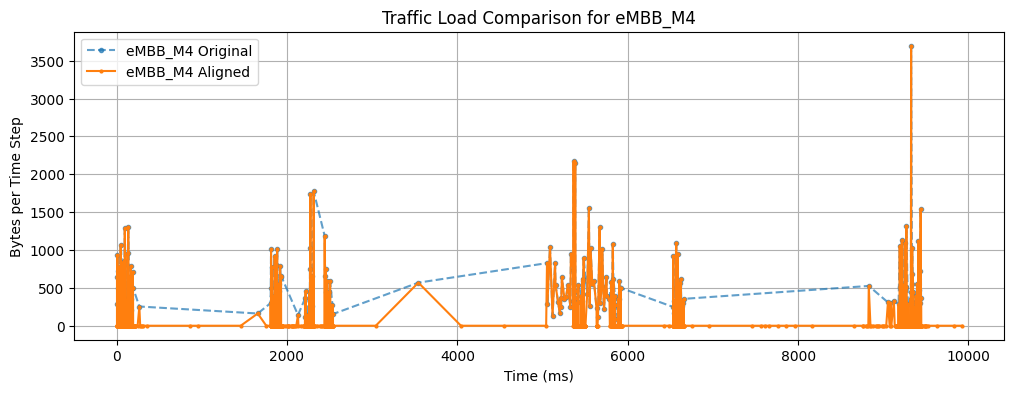

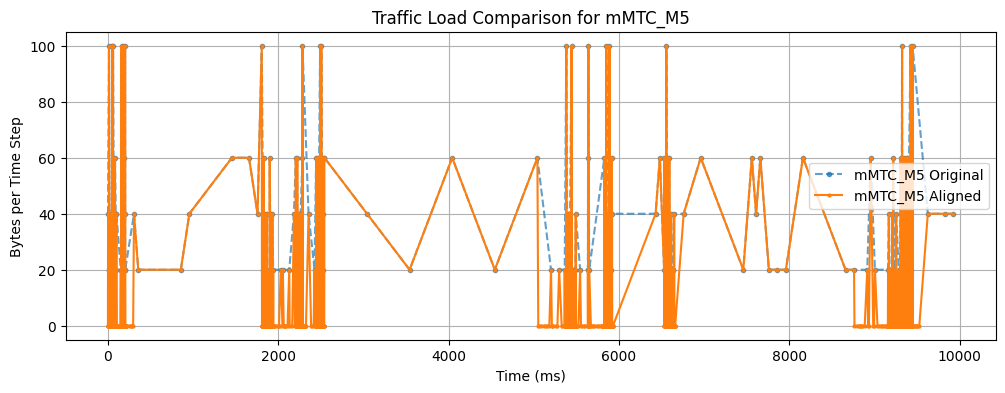

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Base path where your traces are stored
base_path = "../assets/traces"

import os
print("Current working dir:", os.getcwd())

# File dictionary
files = {
    "URLLC_M1": {
        "aligned": os.path.join(base_path, "URLLC_M1_aligned_trace.csv"),
        "original": os.path.join(base_path, "URLLC_M1_trace.csv")
    },
    "URLLC_M2": {
        "aligned": os.path.join(base_path, "URLLC_M2_aligned_trace.csv"),
        "original": os.path.join(base_path, "URLLC_M2_trace.csv")
    },
    "eMBB_M3": {
        "aligned": os.path.join(base_path, "eMBB_M3_aligned_trace.csv"),
        "original": os.path.join(base_path, "eMBB_M3_trace.csv")
    },
    "eMBB_M4": {
        "aligned": os.path.join(base_path, "eMBB_M4_aligned_trace.csv"),
        "original": os.path.join(base_path, "eMBB_M4_trace.csv")
    },
    "mMTC_M5": {
        "aligned": os.path.join(base_path, "mMTC_M5_aligned_trace.csv"),
        "original": os.path.join(base_path, "mMTC_M5_trace.csv")
    }
}

# Plot each UE's original vs aligned
for machine, paths in files.items():
    df_aligned = pd.read_csv(paths["aligned"])
    df_original = pd.read_csv(paths["original"])

    # Aggregate traffic load per time step
    agg_aligned = df_aligned.groupby("Time")["Length"].sum()
    agg_original = df_original.groupby("Time")["Length"].sum()

    # Plot
    plt.figure(figsize=(12, 4))
    plt.plot(agg_original.index, agg_original.values, 
             label=f"{machine} Original", linestyle="--", marker=".", alpha=0.7)
    plt.plot(agg_aligned.index, agg_aligned.values, 
             label=f"{machine} Aligned", linestyle="-", marker="o", markersize=2)

    plt.title(f"Traffic Load Comparison for {machine}")
    plt.xlabel("Time (ms)")
    plt.ylabel("Bytes per Time Step")
    plt.legend()
    plt.grid(True)
    plt.show()


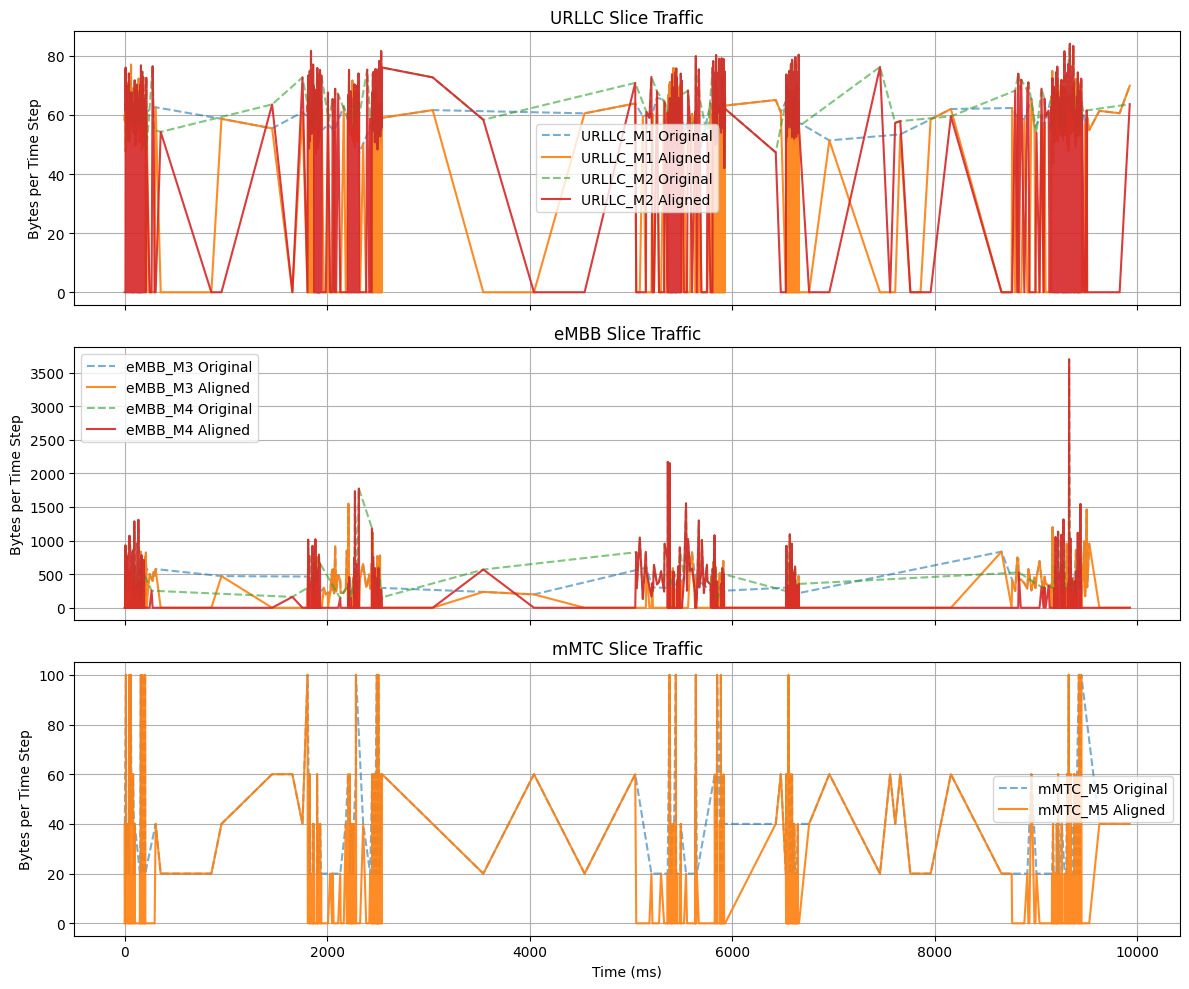

In [6]:
slice_groups = {
    "URLLC": ["URLLC_M1", "URLLC_M2"],
    "eMBB": ["eMBB_M3", "eMBB_M4"],
    "mMTC": ["mMTC_M5"]
}

fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

for ax, (slice_type, ue_list) in zip(axes, slice_groups.items()):
    for ue in ue_list:
        df_aligned = pd.read_csv(files[ue]["aligned"])
        df_original = pd.read_csv(files[ue]["original"])

        agg_aligned = df_aligned.groupby("Time")["Length"].sum()
        agg_original = df_original.groupby("Time")["Length"].sum()

        ax.plot(agg_original.index, agg_original.values, linestyle="--", alpha=0.6, label=f"{ue} Original")
        ax.plot(agg_aligned.index, agg_aligned.values, linestyle="-", alpha=0.9, label=f"{ue} Aligned")

    ax.set_title(f"{slice_type} Slice Traffic")
    ax.set_ylabel("Bytes per Time Step")
    ax.grid(True)
    ax.legend()

plt.xlabel("Time (ms)")
plt.tight_layout()
plt.show()


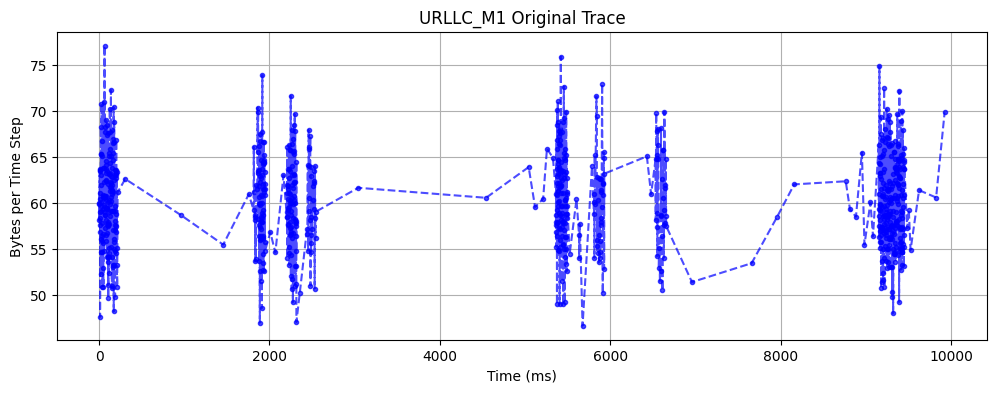

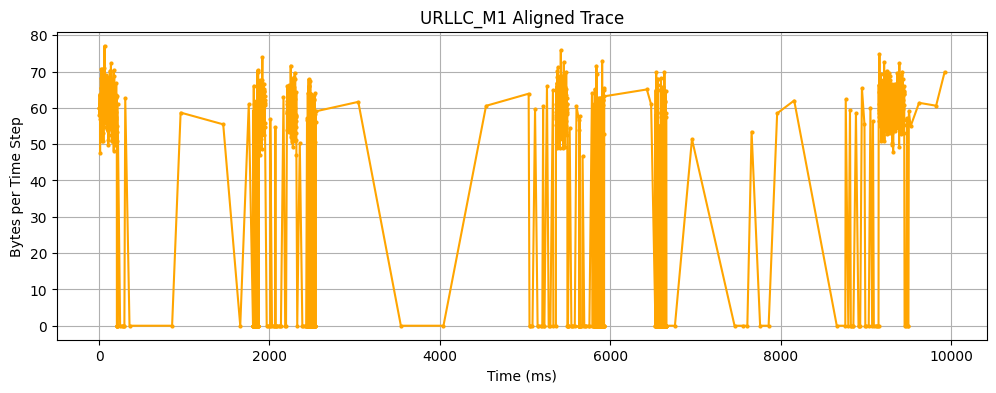

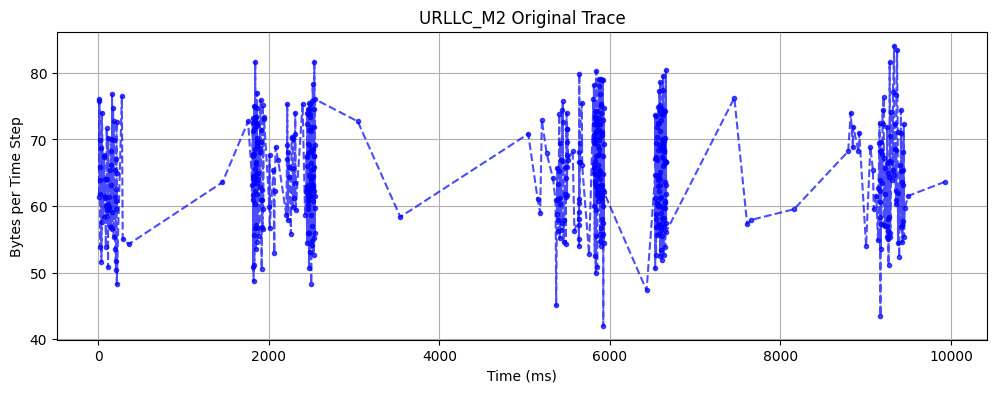

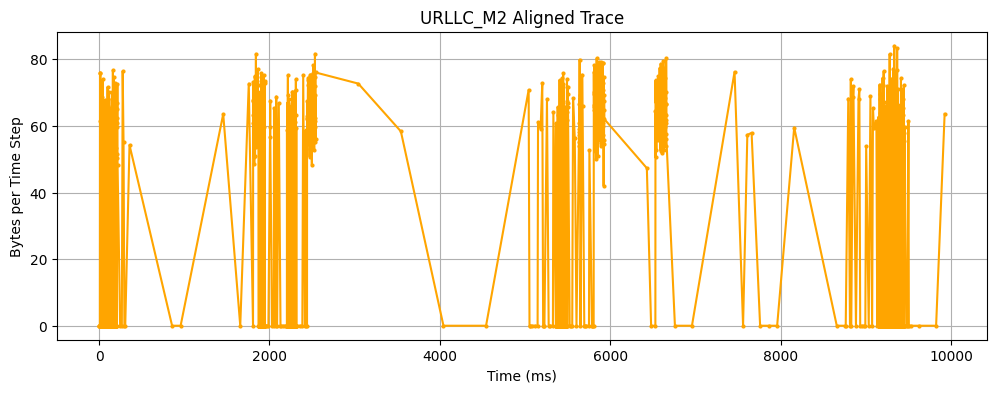

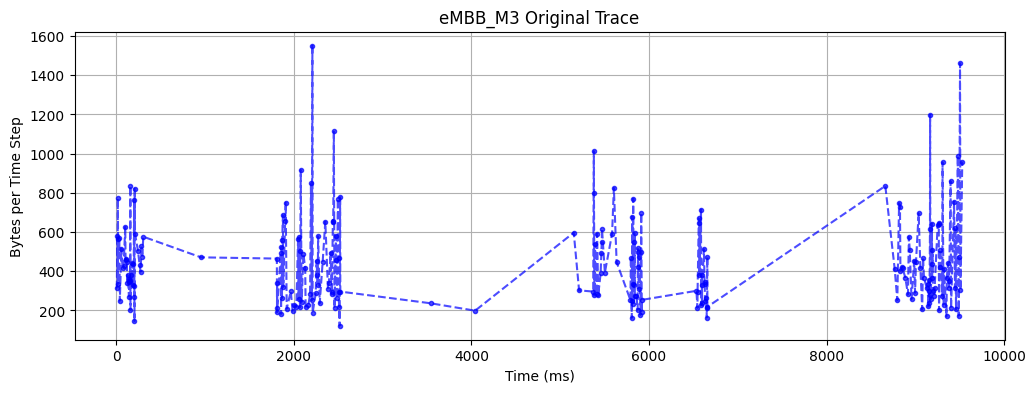

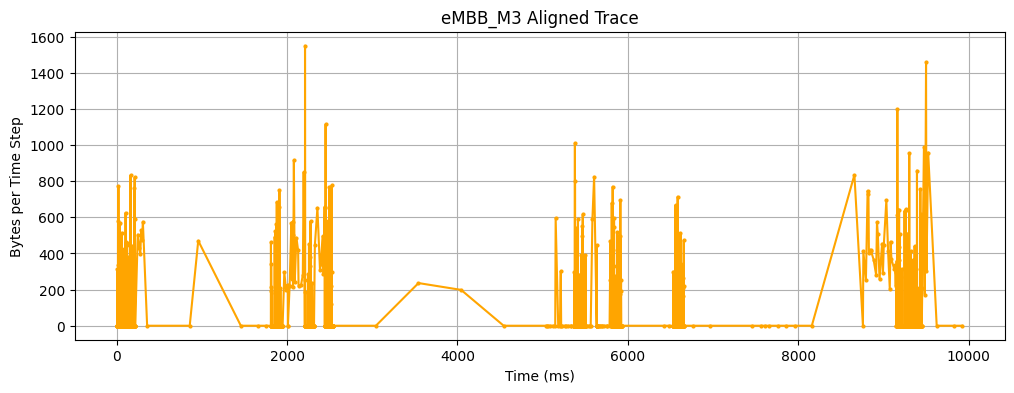

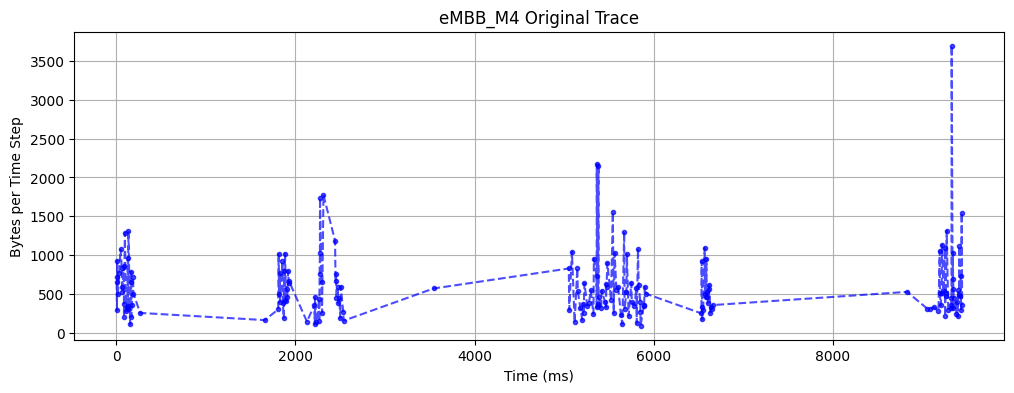

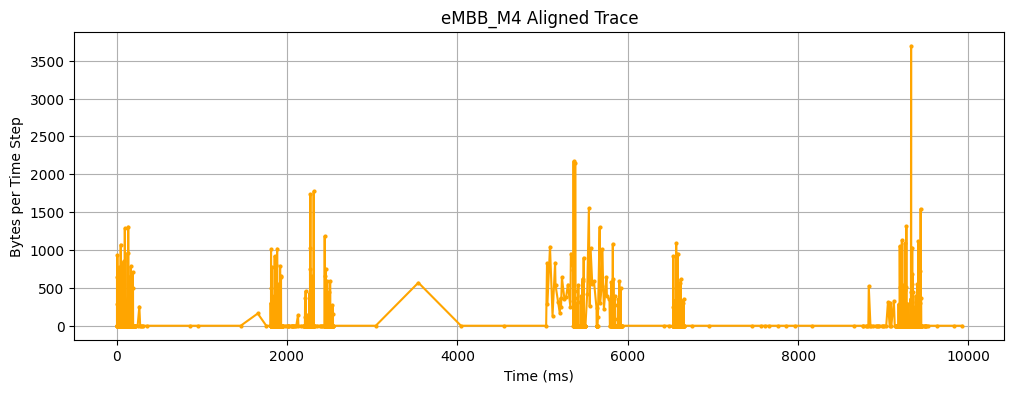

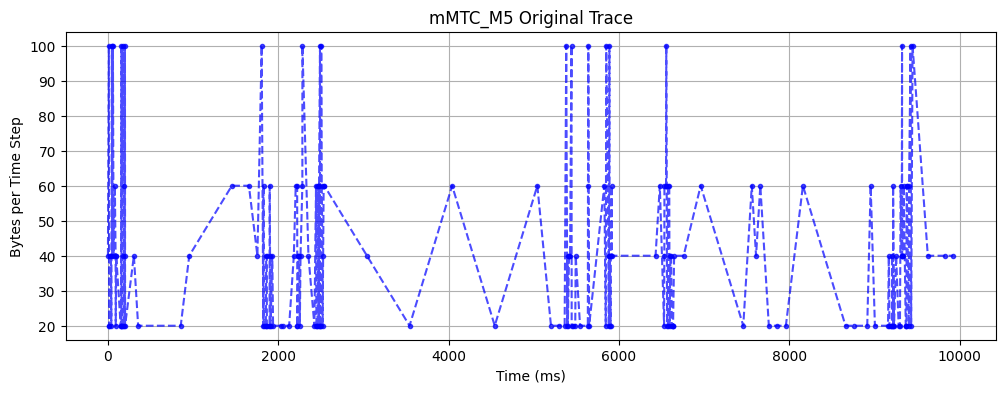

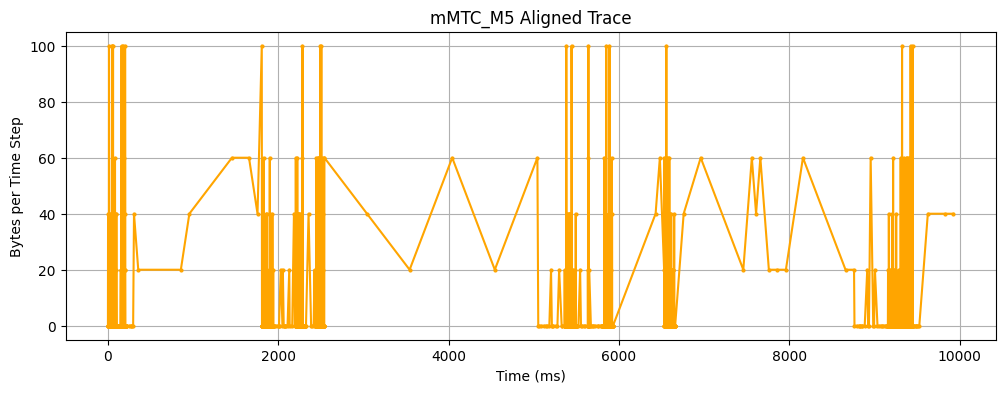

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Base path where your traces are stored
base_path = "../assets/traces"

# File dictionary
files = {
    "URLLC_M1": {
        "aligned": os.path.join(base_path, "URLLC_M1_aligned_trace.csv"),
        "original": os.path.join(base_path, "URLLC_M1_trace.csv")
    },
    "URLLC_M2": {
        "aligned": os.path.join(base_path, "URLLC_M2_aligned_trace.csv"),
        "original": os.path.join(base_path, "URLLC_M2_trace.csv")
    },
    "eMBB_M3": {
        "aligned": os.path.join(base_path, "eMBB_M3_aligned_trace.csv"),
        "original": os.path.join(base_path, "eMBB_M3_trace.csv")
    },
    "eMBB_M4": {
        "aligned": os.path.join(base_path, "eMBB_M4_aligned_trace.csv"),
        "original": os.path.join(base_path, "eMBB_M4_trace.csv")
    },
    "mMTC_M5": {
        "aligned": os.path.join(base_path, "mMTC_M5_aligned_trace.csv"),
        "original": os.path.join(base_path, "mMTC_M5_trace.csv")
    }
}

# Loop through machines and plot separately
for machine, paths in files.items():
    # Load CSVs
    df_aligned = pd.read_csv(paths["aligned"])
    df_original = pd.read_csv(paths["original"])

    # Aggregate traffic load per time step
    agg_aligned = df_aligned.groupby("Time")["Length"].sum()
    agg_original = df_original.groupby("Time")["Length"].sum()

    # Original plot
    plt.figure(figsize=(12, 4))
    plt.plot(agg_original.index, agg_original.values, 
             linestyle="--", marker=".", alpha=0.7, color="blue")
    plt.title(f"{machine} Original Trace")
    plt.xlabel("Time (ms)")
    plt.ylabel("Bytes per Time Step")
    plt.grid(True)
    plt.show()

    # Aligned plot
    plt.figure(figsize=(12, 4))
    plt.plot(agg_aligned.index, agg_aligned.values, 
             linestyle="-", marker="o", markersize=2, color="orange")
    plt.title(f"{machine} Aligned Trace")
    plt.xlabel("Time (ms)")
    plt.ylabel("Bytes per Time Step")
    plt.grid(True)
    plt.show()
